<br />

<div style="text-align: center;">
<font size="7">Training Custom Machine learning Models</font>
<br /> 
<br /> 
<font size="5">PyTorch Cifar10 in Local Mode</font>
    
</div>
<br />


<div style="text-align: right;">
<font size="4">2020/11/11</font>
<br />
<font size="4">Ryutaro Hashimoto</font>
</div>

___

# Summary
- We will use a container image of a pre-built-in SageMaker execution environment and the source code of our own model.
- In this case, we use the Pytorch container image.
- Download the Cifar10 dataset and implement the CNN.
- After downloading the container image, we will set up a container locally and train in the local environment.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Preparing-the-Cifar10-dataset" data-toc-modified-id="Preparing-the-Cifar10-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing the Cifar10 dataset</a></span><ul class="toc-item"><li><span><a href="#2.1.-Download-the-Cifar10-dataset" data-toc-modified-id="2.1.-Download-the-Cifar10-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1. Download the Cifar10 dataset</a></span></li><li><span><a href="#Data-Preview" data-toc-modified-id="Data-Preview-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Preview</a></span></li><li><span><a href="#Upload-the-data" data-toc-modified-id="Upload-the-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Upload the data</a></span></li></ul></li><li><span><a href="#Writing-Model-Scripts" data-toc-modified-id="Writing-Model-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Writing Model Scripts</a></span></li><li><span><a href="#Start-a-learning-job" data-toc-modified-id="Start-a-learning-job-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Start a learning job</a></span></li><li><span><a href="#Deploy-trained-models-and-create-endpoints-for-prediction" data-toc-modified-id="Deploy-trained-models-and-create-endpoints-for-prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Deploy trained models and create endpoints for prediction</a></span></li><li><span><a href="#Invoking-the-endpoint" data-toc-modified-id="Invoking-the-endpoint-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Invoking the endpoint</a></span></li><li><span><a href="#Clean-up" data-toc-modified-id="Clean-up-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Clean-up</a></span></li></ul></div>

## Pre-requisites

In [1]:
!/bin/bash ./setup.sh

sudo: a password is required
The user does not have root access. Everything required to run the notebook is already installed and setup. We are good to go!


Set the bucket, IAM role, and instance type

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-tutorial'
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role_ARN = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx'    # ← your iam role ARN

import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Instance type = local


## Preparing the Cifar10 dataset

### 2.1. Download the Cifar10 dataset

In [3]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### Data Preview

    plane      ship       cat      frog


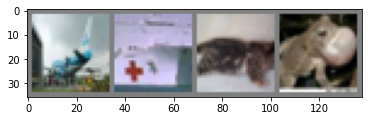

In [4]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [5]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

## Writing Model Scripts
Here is the full code for the network model:

In [6]:
!pygmentize source/cifar10.py

import argparse
import logging
import sagemaker_containers

import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.r

## Start a learning job

In [7]:
from sagemaker.pytorch import PyTorch

inputs = '<S3 path>'
cifar10_estimator = PyTorch(entry_point='source/cifar10.py',
                            role=role_ARN,
                            framework_version='1.4.0',
                            py_version='py3',
                            instance_count=1,
                            instance_type=instance_type)

In [8]:
cifar10_estimator.fit(inputs)

Creating tmpvva33hlv_algo-1-2vnjt_1 ... 
Attaching to tmpvva33hlv_algo-1-2vnjt_12mdone
algo-1-2vnjt_1  | 2021-02-08 02:56:10,849 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-2vnjt_1  | 2021-02-08 02:56:10,866 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-2vnjt_1  | 2021-02-08 02:56:10,880 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-2vnjt_1  | 2021-02-08 02:56:10,890 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-2vnjt_1  | 2021-02-08 02:56:12,015 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
algo-1-2vnjt_1  | Generating setup.py
algo-1-2vnjt_1  | 2021-02-08 02:56:12,016 sagemaker-containers INFO     Generating setup.cfg
algo-1-2vnjt_1  | 2021-02-08 02:56:12,016 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-2vnjt_1  | 2021-02-08 02:56:12,017 sagemaker-conta

algo-1-2vnjt_1  | [1,  4000] loss: 1.812
algo-1-2vnjt_1  | [1,  6000] loss: 1.635
algo-1-2vnjt_1  | [1,  8000] loss: 1.571
algo-1-2vnjt_1  | [1, 10000] loss: 1.491
algo-1-2vnjt_1  | [1, 12000] loss: 1.469
algo-1-2vnjt_1  | [2,  2000] loss: 1.393
algo-1-2vnjt_1  | [2,  4000] loss: 1.371
algo-1-2vnjt_1  | [2,  6000] loss: 1.369
algo-1-2vnjt_1  | [2,  8000] loss: 1.335
algo-1-2vnjt_1  | [2, 10000] loss: 1.296
algo-1-2vnjt_1  | [2, 12000] loss: 1.302
algo-1-2vnjt_1  | Finished Training
algo-1-2vnjt_1  | 2021-02-08 03:11:01,298 sagemaker-containers INFO     Reporting training SUCCESS
tmpvva33hlv_algo-1-2vnjt_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


## Deploy trained models and create endpoints for prediction

In [9]:
from sagemaker.pytorch import PyTorchModel

cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1,
                                             instance_type='local')

Attaching to tmpy5iwy7sb_algo-1-eao2m_1
algo-1-eao2m_1  | 2021-02-08 03:11:22,126 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
algo-1-eao2m_1  | MMS Home: /opt/conda/lib/python3.6/site-packages
algo-1-eao2m_1  | Current directory: /
algo-1-eao2m_1  | Temp directory: /home/model-server/tmp
algo-1-eao2m_1  | Number of GPUs: 0
algo-1-eao2m_1  | Number of CPUs: 4
algo-1-eao2m_1  | Max heap size: 820 M
algo-1-eao2m_1  | Python executable: /opt/conda/bin/python
algo-1-eao2m_1  | Config file: /etc/sagemaker-mms.properties
algo-1-eao2m_1  | Inference address: http://0.0.0.0:8080
algo-1-eao2m_1  | Management address: http://0.0.0.0:8080
algo-1-eao2m_1  | Model Store: /.sagemaker/mms/models
algo-1-eao2m_1  | Initial Models: ALL
algo-1-eao2m_1  | Log dir: /logs
algo-1-eao2m_1  | Metrics dir: /logs
algo-1-eao2m_1  | Netty threads: 0
algo-1-eao2m_1  | Netty client threads: 0
algo-1-eao2m_1  | Default workers per model: 4
algo-1-eao2m_1  | Blacklist Regex: N/A
algo-1-eao2m_1  | Maximum Response 

## Invoking the endpoint

GroundTruth:   cat ship ship plane
algo-1-eao2m_1  | 2021-02-08 03:11:32,607 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 63
algo-1-eao2m_1  | 2021-02-08 03:11:32,609 [INFO ] W-9000-model ACCESS_LOG - /172.28.0.1:38630 "POST /invocations HTTP/1.1" 200 76
Predicted:   cat ship ship ship


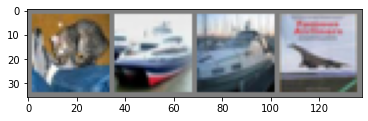

In [10]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

## Clean-up

Deleting the local endpoint when you're finished is important since you can only run one local endpoint at a time.

In [11]:
cifar10_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


In [12]:
# End of File